# Assignment 3: Word2Vec

In this assignment, we will see how we can use Word2Vec (or any similar word embedding) to use information from unlabelled data to help us classify better!

You will be using the sentiment data from last week, either the yelps or movies, whichever you wish. 

Your goal will be to simulate the following situation: you have a **small** set of labelled data and a large set of unlabelled data. Show how the two follow 2 techniques compare as the amount of labelled data increases. You should train them on the small labelled subset and test their performance on the rest of the data. 

In other words, train on 1k, test on 99k. Then train on 2k, test on 98k. Then train on 4k, test on 96k. Etc.

1. Logistic regression trained on labelled data, documents represented as term-frequency matrix of your choice. You can learn the vocabulary from the entire dataset or only the labelled data.

2. Logistic regression trained on the labelled data, documents represented as word2vec vectors where you train word2vec using the entire dataset. Play around with different settings of word2vec (training window size, K-negative, skip-gram vs BOW, training windows, etc.). Note: we didn't go over the options in detail in class, so you will need to read about them a bit!

You can read about the gensime word2vec implementation [here](https://radimrehurek.com/gensim/models/word2vec.html).

In [27]:
import matplotlib.pyplot as plt
import re
import spacy
import seaborn as sns
import pandas as pd
import numpy as np
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split

import cython
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
plt.style.use('ggplot')
%matplotlib inline

In [18]:
movies = pd.read_csv('sentiment/movies.csv')

#there's at least one entry where the column 'positive' is coded as 'positive' and not as 'True' or 'False'
movies.positive[movies.positive=='positive']='True'

In [19]:
not_alphanumeric_or_space = re.compile(r'[^(\w|\s|\d)]')
nlp = spacy.load('en_core_web_sm')

def preprocess(doc):
    #remove punctuation and stopwords and lemmatize, return list of lists
    doc = re.sub(not_alphanumeric_or_space, '', doc)
    words = [t.lemma_.lower() for t in nlp(doc) if t.lemma_ != '-PRON-' and 
             t.lemma_ not in stopwords.words('english')]
    return words

vectorizer = TfidfVectorizer(min_df=2,
                             max_df=.8,
                             preprocessor=None,
                             stop_words=None,
                             use_idf=False,
                             norm=False)

def embed_document(doc, word_vectors):
    doc_sum = np.zeros(word_vectors.vector_size)
    for word in doc:
        try:
            doc_sum += word_vectors.get_vector(word)
        except:
            None
    doc_sum /= np.linalg.norm(doc_sum)
    return doc_sum

def embed_corpus(corpus, word_vectors):
    embedded_docs = np.empty(shape=(len(corpus), word_vectors.vector_size))
    for idx,doc in enumerate(corpus):
        embedded_docs[idx]=embed_document(doc, word_vectors)
    return(embedded_docs)

In [20]:
#lemmatize and remove stop words and punctuation, get a list of lists for Word2vec. I tried lemmatizing vs 
# non lemmatizing, removing stopwords or not, but overall my model with word2vec is a lot better (an increase 
# of more than 20 precentage points in accuracy) when I both lemmatize and remove stop words 
# before trainig the embeddings
movies_prep_words = [preprocess(doc) for doc in movies.text]

#join words back into documents for the vectorizer
movies_prep_docs = [' '.join(doc) for doc in movies_prep_words]

In [74]:
emb_size=150

In [75]:
#train Word2Vec
# I played around a bit with the parameters, skip-gram was really bad in my case, with these parameters it seems to
# work fairly well.
model = Word2Vec(movies_prep_words, min_count=5, size=emb_size, window = 8)
model.train(movies_prep_words, total_examples=len(movies_prep_words), epochs=10)
word_vectors = model.wv
del model

In [76]:
#get embedded representation of the documents
embedded_docs = embed_corpus(movies_prep_words, word_vectors)

In [77]:
# define relative sizes of train dataset and classification model
train_sizes = [.01, .02, .03, .04, .05, .07, .1, .15, .2, .3, .5, .65, .75, .9]
model = LogisticRegression(solver = 'liblinear')

In [78]:
accuracies_simple = np.empty(len(train_sizes))
accuracies_embedded = np.empty(len(train_sizes))

# for each train_size divide dataset in train and test (same documents in train and test for both embedded 
# and non embedded data), fit the model in the two cases and compute accuracy
for idx,train_size in enumerate(train_sizes):
    train_simple, test_simple, train_emb, test_emb, train_y, test_y = train_test_split(movies_prep_docs, 
                                                                                       embedded_docs, 
                                                                                       movies.positive, 
                                                                                       train_size=train_size)
    v = vectorizer.fit_transform(train_simple)
    v_test = vectorizer.transform(test_simple)
    
    model.fit(v, train_y)
    preds = model.predict(v_test)
    accuracy = sum(preds==test_y)/len(test_y)
    accuracies_simple[idx]=accuracy

    model.fit(train_emb, train_y)
    preds = model.predict(test_emb)
    accuracy = sum(preds==test_y)/len(test_y)
    accuracies_embedded[idx]=accuracy

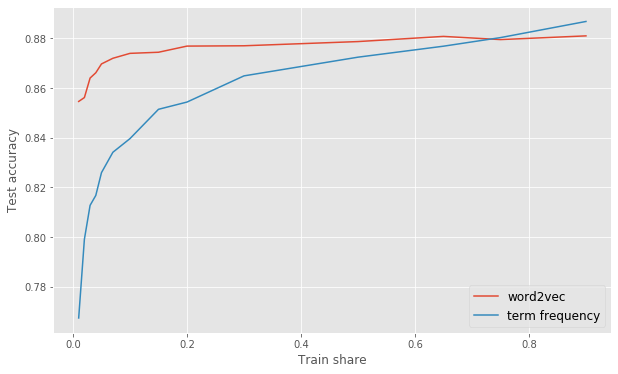

In [89]:
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.set_xlabel('Train share')
ax.set_ylabel('Test accuracy')
ax.plot(train_sizes, accuracies_embedded, label = 'word2vec')
ax.plot(train_sizes, accuracies_simple, label = 'term frequency')
ax.legend(loc='lower right', prop={'size': 12})
plt.show()

From the plot it's quite clear that the word2vec vectors representation for greater accuracy than the tf representation when the train set is small. However, as the train size increases the two models get increasingly close. The other thing worth noticing is that the accuracy of the word2vec model is remarkably steady, changing very little with the sample size after an initial rapid growth.